# Inspect postproces for pe_present_on_image -> pe_exam

tested by exp010, fold0 validation

In [2]:

%cd ~/kaggle/rsna-str/workdir

/home/haito/kaggle/rsna-str/workdir


In [3]:


import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

from src.factory import *
from src.utils import *
from sklearn.metrics import log_loss

In [4]:
DATADIR = Path("../input/rsna-str-pulmonary-embolism-detection/")

train = pd.read_csv(DATADIR / "train.csv")
pre = pd.read_csv(DATADIR / "split.csv")
train = train.merge(pre, on="StudyInstanceUID")

In [5]:
portion = pd.read_csv(DATADIR / "study_pos_portion.csv")
train = train.merge(portion, on="StudyInstanceUID")

In [6]:
t = train[train.fold == 0]

In [7]:
t = t.set_index("SOPInstanceUID")

In [8]:
studies = t.StudyInstanceUID.unique()


In [9]:
agg = t.groupby("StudyInstanceUID")["SOPInstanceUID"].apply(list)
agg_one = t.groupby("StudyInstanceUID").first()

KeyError: 'Column not found: SOPInstanceUID'

In [15]:
# 001
_path = "output/001_base/fold0_valid.pickle"
res = load_pickle(_path)
raw_pred = pd.DataFrame({
    "sop": res["ids"],
    "pe_present": res["outputs"]  # 001
})
raw_pred_001 = raw_pred.set_index("sop")

def get_pred(_path):
    res = load_pickle(_path)
    raw_pred = pd.DataFrame({
        "sop": res["ids"],
        "pe_present": res["outputs"]["pe_present_on_image"]  # 010 or later
    })
    return raw_pred.set_index("sop")

raw_pred_010ep0 = get_pred("output/010_pe_pos/out.valid.fold0")
raw_pred_010ep1 = get_pred("output/010_pe_pos/out.valid.fold0_ep1")
raw_pred_031tune_ep2 = get_pred("output/031_pe_present___oversample___tune/valid.fold0-ep2.pickle")
raw_pred_035ep1 = get_pred("output/035_pe_present___448/valid.fold0-ep1.picle")

In [11]:
def calib_p(arr, factor):  # set factor>1 to enhance positive prob
    return arr * factor / (arr * factor + (1-arr))

In [77]:
raw_pred = raw_pred_010

for factor in [1, 1.5, 2, 4, 8, 16, 32, 64]:
    sops = raw_pred.index
    LABELS = t.loc[sops].pe_present_on_image
    PREDS = raw_pred.pe_present
    PREDS = calib_p(PREDS, factor)
    WEIGHT = t.loc[sops].pe_present_portion
    loss = log_loss(LABELS, PREDS, sample_weight=WEIGHT)
    print(f"factor {factor:2.3f} loss {loss:.4f}")



factor 1.000 loss 0.4607
factor 1.500 loss 0.4084
factor 2.000 loss 0.3757
factor 4.000 loss 0.3128
factor 8.000 loss 0.2747
factor 16.000 loss 0.2644
factor 32.000 loss 0.2848
factor 64.000 loss 0.3378


In [13]:
def search_best(raw_pred):
    best = np.inf
    best_f = -1
    calibrated_probs = None
    for factor in np.logspace(start=0, stop=np.log10(64), num=32, endpoint=True):
        sops = raw_pred.index
        LABELS = t.loc[sops].pe_present_on_image
        PREDS = raw_pred.pe_present
        PREDS = calib_p(PREDS, factor)
        WEIGHT = t.loc[sops].pe_present_portion
        loss = log_loss(LABELS, PREDS, sample_weight=WEIGHT)
        if loss < best:
            best = loss
            best_f = factor
            calibrated_probs = PREDS.copy()
    return best_f, best, calibrated_probs

if False:
    print("raw_pred_001", search_best(raw_pred_001)[:2])
    print("raw_pred_010ep0", search_best(raw_pred_010ep0)[:2])
    print("raw_pred_010ep1", search_best(raw_pred_010ep1)[:2])

In [ ]:
print("raw_pred_035", search_best(raw_pred_031tune_ep2)[:2])

In [14]:
print("raw_pred_035", search_best(raw_pred_035ep1)[:2])

raw_pred_035 (8.555037588568537, 0.23448843275482137)


In [ ]:
"""
■ 001ep1 もともと 0.330087  
factor 1.000 loss 0.3301
factor 1.500 loss 0.3003
factor 2.000 loss 0.2849
factor 4.000 loss 0.2687   <=== BEST
factor 8.000 loss 0.2842
factor 16.000 loss 0.3330
factor 32.000 loss 0.4155
factor 64.000 loss 0.5305

■ 010ep0 もともと 0.460683  <===bestはexp001と同じ. factor=1でみても何も参考にならないことがわかる
factor 1.000 loss 0.4607
factor 1.500 loss 0.4084
factor 2.000 loss 0.3757
factor 4.000 loss 0.3128
factor 8.000 loss 0.2747
factor 16.000 loss 0.2644   <=== BEST
factor 32.000 loss 0.2848
factor 64.000 loss 0.3378

■ 010ep1
factor 1.000 loss 0.4395
factor 1.500 loss 0.3980
factor 2.000 loss 0.3726
factor 4.000 loss 0.3256
factor 8.000 loss 0.3004
factor 16.000 loss 0.2987   <=== BEST
factor 32.000 loss 0.3219
factor 64.000 loss 0.3704


Bestのfactorで比較
Name, factor, weighted-logLoss
raw_pred_001     (3.8250639579850194, 0.26882393843866403)
raw_pred_010ep0 (14.631114282676021,  0.26410222389408655)
raw_pred_010ep1 (11.18792798738602,   0.29658289480177474)
raw_pred_035ep1  (8.555037588568537,  0.23448843275482137)  // 448size

Val exp001
calibなし 0.3300
calibあり 0.2688

LB exp001:
calibなし 0.264
calibあり 0.242

weighted-logloss 0.061 よくなる
＝＞LB 0.022よくなる

LB 0.200にするには、あとweighted-loglossが0.12よくなる (値でいうと 0.268 => 0.150)

-------------------------
calibあり val=0.23448  // exp035: exp001 - 0.034

"""

### smmothing postprocess
median-filter(k=3)は大幅に loss悪化した  
    raw_predsは studyごとにslice順にならんでいるので probsに1d median-filter適用した


In [90]:
factor, loss, probs = search_best(raw_pred_001)

In [101]:
log_loss(LABELS, probs, sample_weight=WEIGHT) == loss

loss

0.26882393843866403

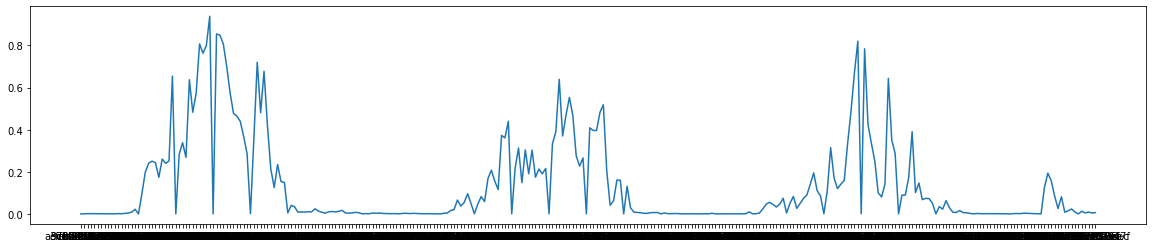

In [121]:
plt.figure(figsize=(20,4))
plt.plot(probs[:300])
plt.show()

In [105]:
def medfilt (x, k):
    """Apply a length-k median filter to a 1D array x.
    Boundaries are extended by repeating endpoints.
    """
    assert k % 2 == 1, "Median filter length must be odd."
    assert x.ndim == 1, "Input must be one-dimensional."
    k2 = (k - 1) // 2
    y = np.zeros ((len (x), k), dtype=x.dtype)
    y[:,k2] = x
    for i in range (k2):
        j = k2 - i
        y[j:,i] = x[:-j]
        y[:j,i] = x[0]
        y[:-j,-(i+1)] = x[j:]
        y[-j:,-(i+1)] = x[-1]
    return np.median (y, axis=1)

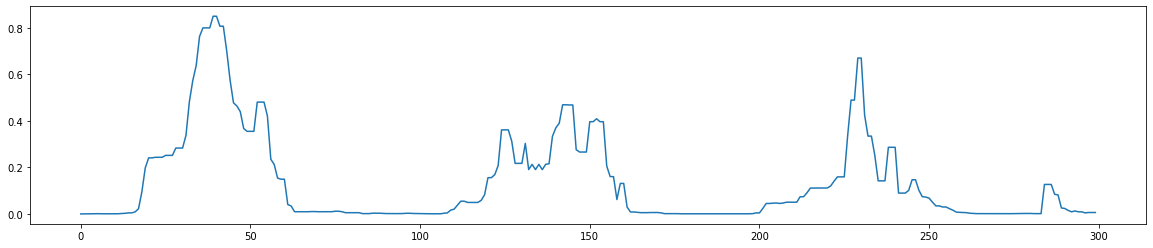

(0.26882393843866403, 0.26882393843866403, 0.810656945917012)

In [122]:
probs_post = medfilt(probs[:300], k=5)
assert len(probs_post) == 300
plt.figure(figsize=(20,4))
plt.plot(probs_post)
plt.show()

log_loss(LABELS, probs, sample_weight=WEIGHT) , \
log_loss(LABELS, medfilt(probs, k=1), sample_weight=WEIGHT) , \
log_loss(LABELS, medfilt(probs, k=3), sample_weight=WEIGHT) 